# Install Libraries

In [381]:
!pip install ipywidgets tqdm > /dev/null 2>&1

# Import Libraries

In [382]:
import os
import torch
import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import joblib

import random

import matplotlib.pyplot as plt

## Lib Version

In [383]:
print("PyTorch:", torch.__version__)
print("OpenCV:", cv2.__version__)

PyTorch: 2.4.0
OpenCV: 4.10.0


## Config

In [384]:
class CFG:
    verbose = 1  # Verbosity
    seed = 35  # Random seed
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [400, 300]  # Input image size
    epochs = 13 # Training epochs
    batch_size = 64  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
    label2name = dict(enumerate(class_names))
    name2label = {v:k for k, v in label2name.items()}

In [385]:
torch.manual_seed(CFG.seed)
random.seed(CFG.seed)
np.random.seed(CFG.seed)

## Dataset Path

In [386]:
BASE_PATH = "../data"

SPEC_DIR = "./tmp/dataset/hms-hbac"

# Make dirs to hold train test split data
os.makedirs(SPEC_DIR + '/train_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR + '/test_spectrograms', exist_ok=True)

In [387]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')

df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{SPEC_DIR}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.npy'
df['class_name'] = df.expert_consensus.copy()
df['class_label'] = df.expert_consensus.map(CFG.name2label)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['eeg_path'] = f'{BASE_PATH}/test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'{BASE_PATH}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'
test_df['spec2_path'] = f'{SPEC_DIR}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.npy'
display(test_df.head(2))

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec2_path,class_name,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,../data/train_eegs/1628180742.parquet,../data/train_spectrograms/353733.parquet,./tmp/dataset/hms-hbac/train_spectrograms/3537...,Seizure,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,../data/train_eegs/1628180742.parquet,../data/train_spectrograms/353733.parquet,./tmp/dataset/hms-hbac/train_spectrograms/3537...,Seizure,0


,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path,spec2_path
0,853520,3911565283,6885,../data/test_eegs/3911565283.parquet,../data/test_spectrograms/853520.parquet,./tmp/dataset/hms-hbac/test_spectrograms/85352...


In [388]:
# Define a function to process a single eeg_id
def process_spec(spec_id, split="train"):
    spec_path = f"{BASE_PATH}/{split}_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
    spec = spec.fillna(0).values[:, 1:].T # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec = spec.astype("float32")
    np.save(f"{SPEC_DIR}/{split}_spectrograms/{spec_id}.npy", spec)

# Get unique spec_ids of train and valid data
spec_ids = df["spectrogram_id"].unique()

# Parallelize the processing using joblib for training data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "train")
    for spec_id in tqdm(spec_ids, total=len(spec_ids))
)

# Get unique spec_ids of test data
test_spec_ids = test_df["spectrogram_id"].unique()

# Parallelize the processing using joblib for test data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "test")
    for spec_id in tqdm(test_spec_ids, total=len(test_spec_ids))
)

100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1096.55it/s]


In [389]:
spec_path = f"{BASE_PATH}/train_spectrograms/{spec_ids[0]}.parquet"
spec = pd.read_parquet(spec_path)
print(spec.head())

   time  LL_0.59  LL_0.78  LL_0.98  LL_1.17  LL_1.37    LL_1.56    LL_1.76  \
0     1     4.26    10.98     9.05    13.65    11.49   8.930000  18.840000   
1     3     2.65     3.97    12.18    13.26    14.21  13.230000   9.650000   
2     5     4.18     4.53     8.77    14.26    13.36  16.559999  19.219999   
3     7     2.41     3.21     4.92     8.07     5.97  12.420000  10.820000   
4     9     2.29     2.44     2.77     4.62     5.39   7.080000   9.840000   

   LL_1.95    LL_2.15  ...  RP_18.16  RP_18.36  RP_18.55  RP_18.75  RP_18.95  \
0    19.26  19.240000  ...      0.31      0.17      0.28      0.19      0.24   
1     8.11  11.280000  ...      0.15      0.13      0.14      0.24      0.24   
2    17.51  22.650000  ...      0.29      0.21      0.16      0.25      0.28   
3    14.96  21.809999  ...      0.33      0.51      0.49      0.64      0.58   
4    12.27  14.410000  ...      0.44      0.38      0.48      0.63      0.45   

   RP_19.14  RP_19.34  RP_19.53  RP_19.73  RP_19.9

In [390]:
spec_path = f"{BASE_PATH}/train_spectrograms/{spec_ids[0]}.parquet"
spec = pd.read_parquet(spec_path)
spec = spec.fillna(0).values[:, 1:].T
print(spec.shape)
print(spec)


(400, 320)
[[ 4.26000023  2.6500001   4.17999983 ...  6.07000017  3.41000009
   2.88000011]
 [10.97999954  3.97000003  4.53000021 ...  7.8499999   3.75
   3.71000004]
 [ 9.05000019 12.18000031  8.77000046 ... 11.26000023  4.80000019
   4.01999998]
 ...
 [ 0.16        0.31        0.47999999 ...  0.09        0.16
   0.09      ]
 [ 0.22        0.36000001  0.44       ...  0.17        0.19
   0.07      ]
 [ 0.19        0.40000001  0.47999999 ...  0.12        0.19
   0.05      ]]


In [391]:
spec_path = f"{BASE_PATH}/train_spectrograms/{spec_ids[0]}.parquet"
spec = pd.read_parquet(spec_path)
spec = spec.fillna(0).values[:, 1:].T
print(spec.shape)
print(spec)

(400, 320)
[[ 4.26000023  2.6500001   4.17999983 ...  6.07000017  3.41000009
   2.88000011]
 [10.97999954  3.97000003  4.53000021 ...  7.8499999   3.75
   3.71000004]
 [ 9.05000019 12.18000031  8.77000046 ... 11.26000023  4.80000019
   4.01999998]
 ...
 [ 0.16        0.31        0.47999999 ...  0.09        0.16
   0.09      ]
 [ 0.22        0.36000001  0.44       ...  0.17        0.19
   0.07      ]
 [ 0.19        0.40000001  0.47999999 ...  0.12        0.19
   0.05      ]]


In [392]:
spec = pd.read_parquet(spec_path)
spec = spec.fillna(0).values[:, 1:].T
print(f"Min value: {spec.min()}, Max value: {spec.max()}")


Min value: 0.019999999552965164, Max value: 73.16999816894531


In [393]:
from torch.utils.data import Dataset

# Init. Image Visualization

## Custom DataSet

In [421]:
import torch.nn.functional as F

In [422]:
class EEGDataset(Dataset):
    def __init__(self, df, data_dir, mode="train", transform=None, augment=None):
        self.df = df
        self.data_dir = data_dir
        self.mode = mode
        self.transform = transform
        self.augment = augment

        self.spec_paths = self.df['spec2_path'].values
        if mode != "test":
            self.labels = self.df['class_label'].values

    def __len__(self):
        return len(self.df)

    def preprocess(self, spectrogram):
        """
        Apply log transformation, normalization, and enforce a consistent size.
        """
        # Clip the spectrogram to [400, 300] or pad it accordingly
        target_width = 300
        if spectrogram.shape[1] > target_width:
            spectrogram = spectrogram[:, :target_width]  # Trim to the target width
        else:
            pad_width = target_width - spectrogram.shape[1]
            spectrogram = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
    
        # Log transform to enhance smaller values and reduce large outliers
        spectrogram = np.clip(spectrogram, a_min=np.exp(-4.0), a_max=np.exp(8.0))  # avoid log(0)
        spectrogram = np.log(spectrogram)
        
        # Normalize to zero mean and unit variance
        spectrogram -= np.mean(spectrogram)
        spectrogram /= (np.std(spectrogram) + 1e-6)

        # Stack grayscale image into 3 channels for compatibility with ImageNet models
        spectrogram = np.stack([spectrogram] * 3, axis=-1)  # Shape will be (H, W, 3)
    
        return spectrogram

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        spec_path = self.spec_paths[idx]
        spectrogram = np.load(spec_path)
    
        # Apply preprocessing
        spectrogram = self.preprocess(spectrogram)
    
        # Apply any transformation if provided (e.g., resizing, augmentation)
        if self.transform:
            spectrogram = self.transform(spectrogram)
    
        # Convert to tensor if not already a tensor
        if not isinstance(spectrogram, torch.Tensor):
            spectrogram = torch.tensor(spectrogram, dtype=torch.float32).permute(2, 0, 1)  # (H, W, C) -> (C, H, W)
    
        # Apply augmentation if provided
        if self.augment and self.mode == "train":
            spectrogram = self.augment(spectrogram)
        
        if self.mode != "test":
            # One-hot encode labels
            label = F.one_hot(torch.tensor(self.labels[idx]), num_classes=len(self.df['class_label'].unique()))
            label = label.float()  # Convert to float for compatibility with certain losses like KL Divergence
            return spectrogram, label
        else:
            return spectrogram


## Transforms

In [423]:
import torchvision.transforms as transforms

In [424]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((400, 300))  # Resizing to a fixed size (height, width)
])

## Augmentations

In [425]:
from torchvision.transforms import v2

In [426]:
augment = transforms.Compose([
    v2.MixUp(alpha = 1.0),
    transforms.RandomErasing(
        p=0.5,
        scale=(0.06, 0.10),
        ratio=(8, 12), # freq mask
        value='random',
        inplace=False
    ),
    transforms.RandomErasing(
        p=0.5,
        scale=(0.06, 0.10),
        ratio=(0.1, 0.5), # freq mask
        value='random',
        inplace=False
    )
])

## Init. Train, Test Datasets + DataLoaders

In [427]:
train_dataset = EEGDataset(df=df, data_dir=f"{SPEC_DIR}/train_spectrograms", mode="train", transform=transform, augment=random_cutout)
test_dataset = SpectrogramDataset(df=test_df, data_dir=f"{SPEC_DIR}/test_spectrograms", mode="test")

In [428]:
from torch.utils.data import DataLoader

In [429]:
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False)

In [454]:
def visualize_batch(data_loader, num_samples=4):
    # Get the first batch from the DataLoader
    for spectrograms, labels in data_loader:
        fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
        
        for i in range(num_samples):
            ax = axes[i]
            # Extract the first channel (since all channels are identical after stacking)
            spec = spectrograms[i][0].numpy()  # Extract the first channel
            
            # Normalize the image for better color scaling
            spec -= spec.min()
            spec /= spec.max() + 1e-4
            
            # Convert one-hot encoded label to the class index
            label_index = torch.argmax(labels[i]).item()
            
            # Display the image with a colormap, adjusting the origin
            cax = ax.imshow(spec, aspect='auto', origin='lower', cmap='viridis')
            ax.set_title(f"Label: {CFG.label2name[label_index]}")
            ax.set_xlabel("Time")
            ax.set_ylabel("Frequency")
            fig.colorbar(cax, ax=ax)
        
        plt.tight_layout()
        plt.show()
        
        # Break after the first batch
        break

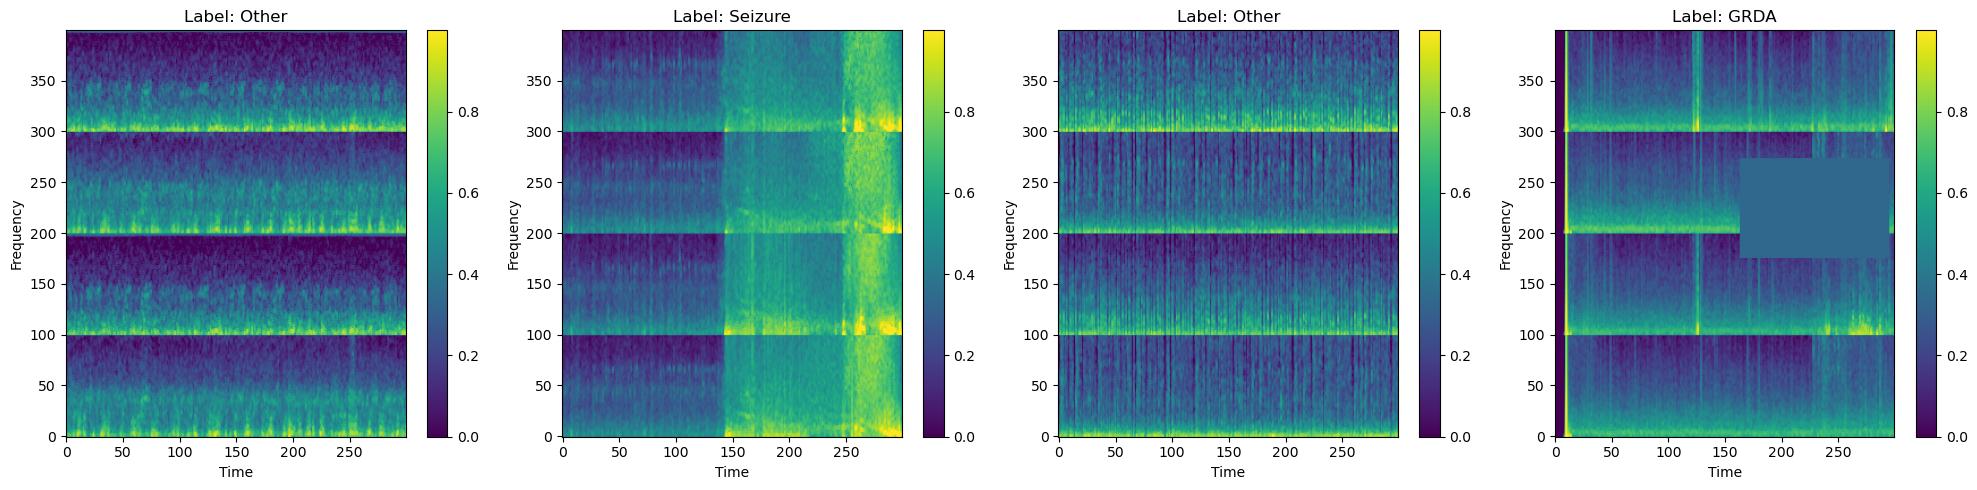

In [455]:
# Visualize the first few samples in the DataLoader
visualize_batch(train_loader, num_samples=4)